## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



<a id='probability'></a>
#### Part I - Probability



In [44]:
# import libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

1a

In [2]:
# read in data set an create data frame
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


1b

In [3]:
# number of rows in dataset
df.shape[0]

294478

1c

In [4]:
# number of unique users in dataset
df['user_id'].nunique()

290584

1d

In [5]:
# proportion of users converted
df['converted'].mean()

0.11965919355605512

1e

In [6]:
# number of not matches of new_page and treatment and old_page and control
df.query('group == "control" & landing_page == "new_page" or group == "treatment" & landing_page == "old_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

1f

In [7]:
# assess for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


2a

In [8]:
# delete rows where control and old_page and treatment and new_page do not match
df2 = df.query('group == "control" & landing_page == "old_page" or group == "treatment" & landing_page == "new_page"')

2b

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3a

In [10]:
# number of unique users in df2
df2['user_id'].nunique()

290584

3b

In [11]:
# create filter for duplicated user
fil = df2['user_id'].duplicated()
df2[fil]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


3c

In [12]:
# display duplicated rows
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


3d

In [13]:
# remove duplication
df2.drop([1899], axis=0, inplace=True)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
# control success
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


4a

In [15]:
# probability of converting regardless of received page
df2['converted'].mean()

0.11959708724499628

4b

In [16]:
# create data frame for control group
df_control = df2[df2['group'] == 'control']
df_control.shape

(145274, 5)

In [17]:
# probability of conversion of control group
df_control_convrate = df_control['converted'].mean()
df_control_convrate

0.1203863045004612

4c

In [18]:
# create data frame for treatment group
df_treatment = df2[df2['group'] == 'treatment']
df_treatment.shape

(145310, 5)

In [19]:
# probability of conversion of treatment group
df_treatment_convrate = df_treatment['converted'].mean()
df_treatment_convrate

0.11880806551510564

In [20]:
# calculate observed difference for sample
obs_diff = df_treatment_convrate - df_control_convrate
obs_diff

-0.0015782389853555567

4d

In [21]:
# probability of receiving new page
df2[df2['landing_page'] == 'new_page']['landing_page'].count()/df2['landing_page'].count()

0.5000619442226688

4e

**From the above lines I conclude that there probably is not enough evidence to support the hypothesis that the new page generates more conversions. First, there seems to be a higher conversion rate in the control group in the sample, which also renders the observed difference negativ.**

<a id='ab_test'></a>
### Part II - A/B Test

1

H0: **$p_{new}$**- **$p_{old}$** =< 0

H1: **$p_{new}$** - **$p_{old}$** > 0

2a

In [22]:
# conversion rate for p_new under the null
df2.converted.mean()

0.11959708724499628

2b

In [23]:
# conversion rate for p_old under the null
df2.converted.mean()

0.11959708724499628

2c

In [24]:
# number of individuals in treatment group n_new
df_treatment.shape[0]

145310

2d

In [25]:
# number of individuals in control group n_old
df_control.shape[0]

145274

2e

In [26]:
# simulate n_new transactions under the null and store results
new_page_converted = df_treatment.sample(df_treatment.shape[0], replace = True)

2f

In [27]:
# simulate n_old transactions under the null and store results
old_page_converted = df_control.sample(df_control.shape[0], replace = True)

2g

In [28]:
# calculate difference in sampled conversion mean for treatment and control group part 1
p_new = new_page_converted.converted.mean()
p_new

0.11789966278989746

In [29]:
# calculate difference in sampled conversion mean for treatment and control group part 2
p_old = old_page_converted.converted.mean()
p_old

0.12096452221319713

In [30]:
# calculate difference in sampled conversion mean for treatment and control group part 3
obs_diff1 = p_new - p_old
obs_diff1

-0.003064859423299676

2h

In [31]:
# create a sample distribution with bootstrapping for differences in conversion mean between treatment and control group
p_diffs = []
for _ in range(10000):
    new_page_converted = df_treatment.sample(df_treatment.shape[0], replace = True)
    old_page_converted = df_control.sample(df_control.shape[0], replace = True)
    p_new = new_page_converted.converted.mean()
    p_old = old_page_converted.converted.mean()
    p_diffs.append(p_new - p_old)

In [32]:
# convert list to numpy array
p_diffs = np.array(p_diffs)

In [33]:
# simulate a sampling distribution from the null hypothesis
null_vals = np.random.normal(0, np.std(p_diffs), 10000)

2i

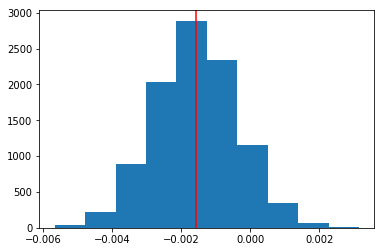

In [34]:
# plot sample distribution
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color = 'red');

**The plot looks like what I am expected because it is centered around the observed difference which should be an indicator for where the value range of the parameter will be. Furthermore, it is normally distributed which would be expected from the central limit theorem.**

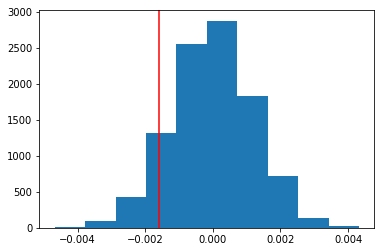

In [35]:
# plotting sampling distribution from null hypothesis
plt.hist(null_vals)
plt.axvline(x=obs_diff, color = 'red');

**The sampling distribution from the null hypothesis looks like expected. Centered around 0 and normally distributed. The observed difference of the sample falls within the range of the null hypothesis distribution. This indicates that we cannot reject the null hypothesis.**

2j

In [36]:
# calculate p-value
(null_vals > obs_diff).mean()

0.9004

2k

**In 2j we computed the p-value. The p-value is a measure of the probability of finding statistics equal to or greater than the observed difference from the null given H0 is true. This means if p -value is large H0 cannot be rejected and if it is small H0 can be rejected. Whether it is considered large or small depends on alpha. In this case alpha is 5% or 0.05. Therefore, the p-value is greater than alpha and H0 cannot be rejected. According to the hypotheses we stated we can conclude that there seems to be no difference between the two pages concerning conversion rates. Therefore, the new page should not be introduced for the reason of increasing conversion rates.**

2l

In [37]:
# build 2 data frames of converted users from treatment and control group
df_treatment_conv = df_treatment[df_treatment['converted'] == 1]
df_control_conv = df_control[df_control['converted'] == 1]

In [38]:
# define parameters to be used in Z Test
convert_old = df_control_conv.shape[0]
convert_new = df_treatment_conv.shape[0]
n_old = df_control.shape[0]
n_new = df_treatment.shape[0]
value = 0
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

2m

In [39]:
# compute test statistic and p value with Z test
stats, pval = sm.stats.proportions_ztest(count, nobs, value)
stats, pval

(1.3109241984234394, 0.18988337448195103)

2n

**Like in 2j and 2k the p - value does not show statistical significance as it is > than alpha of 0.05. Therefore, H0 cannot be rejected. Thus, also this statistic tells us that the conversion rate does not seem to increase with the new page. The z-score is not considered as it is used to calculate the p - value and hence will not deviate from the evidence of the p -value.**

<a id='regression'></a>
### Part III - A regression approach

1a

**I will perform Logistic Regression since there is only the possibility of 0 or 1 i.e. no conversion or conversion**

1b

In [40]:
# ad an intercept and dummy variables as a preparation for the regression
df2['intercept'] = 1
df2[['x', 'ab_page']] = pd.get_dummies(df['group'])

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [41]:
# inspect data
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


1c 

In [42]:
# create logistic regression model to predict conversion depending on page displayed
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
# fit model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


1d

In [45]:
# show results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:31:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

1e

**Interpretation: The p value of ab_page of 0.19 tells us that this variable is not statistically significant in explaining conversion or no conversion. In other words there is no effect on conversion rate from the type of page (old or new) a user receives. This again indicates that there is no need to launch the new page because there seems to be no effect on the conversion rate. The difference between the p-value of the logistic regression and the p-value of the hypothesis testing in Part II stems from the differences in the hypotheses. In Part II the hypotheses were mathematically derived from the differences of the probabilities of conversion dependend on the old page and the new page whereas in the logistic regression model the hypotheses are mathematically derived from the probability of converting depending on the kind of page displayed (old or new). See also z-test.**

1f

**Discussion of using additional items: As the conversion rate is not influenced by the page design it is a good idea to consider other factors in order to use the gathered data to their full extent.  Otherwise the efforts in gathering the data would be wasted. It is for sure easier and cheaper to do analyses of existent data than to gather data.If on the other side all other data had been analyzed already beforehand then an additional analysis should not be performed. The caveat is that with adding additional items to a regression model one of these items may be statistically signifcant just by chance.**

1g

In [46]:
# read in country data
df_country = pd.read_csv('countries.csv')
# inspect data
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# inspect which countries are recorded
df_country.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [48]:
# inspect data
df_country.shape

(290584, 2)

In [49]:
# sort values for merging data frames
df2_sorted = df2.sort_values(by=['user_id'])
# inspect data
df2_sorted.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page
63114,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1
103873,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1
205236,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0
247344,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1
242283,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1


In [50]:
# reset index
df2_sort_idx = df2_sorted.reset_index(drop=True)
# inspect data
df2_sort_idx.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1


In [51]:
# sort values for merging data frames
df_country_sorted = df_country.sort_values(by=['user_id'])
# inspect data
df_country_sorted.head()

,user_id,country
101274,630000,US
23584,630001,US
138444,630002,US
21396,630003,US
105911,630004,US


In [52]:
# reset index
df_count_idx = df_country_sorted.reset_index(drop=True)
# inspect data
df_count_idx.head()

,user_id,country
0,630000,US
1,630001,US
2,630002,US
3,630003,US
4,630004,US


In [53]:
# drop user id as it is already contained in df2
df_count_idx.drop(['user_id'], axis=1, inplace=True)
# inspect data
df_count_idx.head()

,country
0,US
1,US
2,US
3,US
4,US


In [54]:
# merge data frames
df_merged = pd.concat([df2_sort_idx, df_count_idx], axis=1)
# inspect data
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US


In [55]:
# get dummy variables for the different countries
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
# inspect data
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,UK,US
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,0,1
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,0,1
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,0,1
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,0,1
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,0,1


In [56]:
# create logistic regression model to predict conversion depending on country
logit_mod1 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US']])
# fit model
results1 = logit_mod1.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [57]:
# show results
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               1.521e-05
Time:                        21:32:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**For country variables the p- values do not show statistical significance on the alpha = 0.05 level. This is they do not explain conversion versus non conversion. Therfore from this data we cannot draw any conclusion that investing in a specific country for attracting more students to subscribe a course is useful. It seems that for the data of the pages and countries we considered there is no practical conclusion we can draw that would help economic decisions.**

1h

In [58]:
# create interaction term of page displayed and country step 1
df_merged['page_CA'] = df_merged['ab_page'] * df_merged['CA']

In [59]:
# create interaction term of page displayed and country step 2
df_merged['page_UK'] = df_merged['ab_page'] * df_merged['UK']

In [60]:
# create interaction term of page displayed and country step 3
df_merged['page_US'] = df_merged['ab_page'] * df_merged['US']

In [61]:
# inspect data
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,UK,US,page_CA,page_UK,page_US
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,0,1,0,0,1
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,0,1,0,0,0
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1


In [62]:
# build logistic regression model with interaction terms
logit_mod2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'page_UK', 'page_US']])
# fit model
results2 = logit_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [63]:
# show results
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:32:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
page_UK        0.0783      0.057      1.378      0.168      -0.033       0.190
page_US        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**Neither of the new variables lead to more information or a significant result. So we cannot draw any conclusion that launching the new page in a specific country would be beneficial for conversion rates.**

**Next I will incorporate time data to see if there are differences in speed or time slots of conversion.**

In [64]:
df_merged['timestamp'].max(), df_merged['timestamp'].min()

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

In [65]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 15 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
x               290584 non-null uint8
ab_page         290584 non-null uint8
country         290584 non-null object
CA              290584 non-null uint8
UK              290584 non-null uint8
US              290584 non-null uint8
page_CA         290584 non-null uint8
page_UK         290584 non-null uint8
page_US         290584 non-null uint8
dtypes: int64(3), object(4), uint8(8)
memory usage: 17.7+ MB


In [66]:
df_merged['Timestamp'] = pd.to_datetime(df_merged['timestamp'])

In [67]:
df_merged['weekday'] = df_merged['Timestamp'].apply(lambda x: x.weekday())
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,UK,US,page_CA,page_UK,page_US,Timestamp,weekday
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-19 06:26:06.548941,3
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,0,1,0,0,1,2017-01-16 03:16:42.560309,0
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,0,1,0,0,0,2017-01-19 19:20:56.438330,3
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-12 10:09:31.510471,3
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-18 20:23:58.824994,2


In [68]:
bin_edges = [-1, 4, 6]
bin_labels = ['weekday', 'weekend']

In [69]:
df_merged['weekend'] = pd.cut(df_merged['weekday'], bin_edges, labels=bin_labels )
df_merged

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,UK,US,page_CA,page_UK,page_US,Timestamp,weekday,weekend
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-19 06:26:06.548941,3,weekday
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,0,1,0,0,1,2017-01-16 03:16:42.560309,0,weekday
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,0,1,0,0,0,2017-01-19 19:20:56.438330,3,weekday
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-12 10:09:31.510471,3,weekday
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-18 20:23:58.824994,2,weekday
5,630005,2017-01-17 21:22:25.940766,treatment,new_page,1,1,0,1,US,0,0,1,0,0,1,2017-01-17 21:22:25.940766,1,weekday
6,630006,2017-01-14 05:13:51.962356,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-14 05:13:51.962356,5,weekend
7,630008,2017-01-11 16:11:11.131461,control,old_page,0,1,1,0,US,0,0,1,0,0,0,2017-01-11 16:11:11.131461,2,weekday
8,630009,2017-01-05 23:35:15.820565,control,old_page,1,1,1,0,US,0,0,1,0,0,0,2017-01-05 23:35:15.820565,3,weekday
9,630010,2017-01-06 16:36:05.678507,treatment,new_page,0,1,0,1,UK,0,1,0,0,1,0,2017-01-06 16:36:05.678507,4,weekday


In [70]:
df_merged[['weekday_1', 'weekend_1' ]] = pd.get_dummies(df_merged['weekend'])

In [71]:
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,UK,US,page_CA,page_UK,page_US,Timestamp,weekday,weekend,weekday_1,weekend_1
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-19 06:26:06.548941,3,weekday,1,0
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,0,1,0,0,1,2017-01-16 03:16:42.560309,0,weekday,1,0
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,0,1,0,0,0,2017-01-19 19:20:56.438330,3,weekday,1,0
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-12 10:09:31.510471,3,weekday,1,0
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,0,1,0,0,1,2017-01-18 20:23:58.824994,2,weekday,1,0


In [72]:
df_merged[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']] = pd.get_dummies(df_merged['weekday'])

In [73]:
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,...,weekend,weekday_1,weekend_1,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,...,weekday,1,0,0,0,0,1,0,0,0
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,...,weekday,1,0,1,0,0,0,0,0,0
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,...,weekday,1,0,0,0,0,1,0,0,0
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,...,weekday,1,0,0,0,0,1,0,0,0
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,...,weekday,1,0,0,0,1,0,0,0,0


In [74]:
# build a logistic regression model for weekdays versus weekend
logit_mod3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'weekday_1']])
# fit the model
results3 = logit_mod3.fit()

Optimization terminated successfully.
         Current function value: 0.366121
         Iterations 6


In [75]:
# show results
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               1.154e-08
Time:                        21:33:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.9605
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9958      0.011   -182.729      0.000      -2.017      -1.974
weekday_1     -0.0006      0.013     -0.050      0.960      -0.026       0.024
==============================================================================
"""

**Also for these variables the p- value does not show statistical significance on the alpha = 0.05 level. Therefore also these variables to not contribute in explaining conversion version non conversion.**

In [76]:
# build a logistic regression model for the single days of a week
logit_mod5 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']])
# fit the model
result5 = logit_mod5.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [77]:
# show results
result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               2.601e-05
Time:                        21:33:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4773
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0069      0.015   -129.579      0.000      -2.037      -1.977
Monday         0.0254      0.021      1.200      0.230      -0.016       0.067
Tuesday        0.0101      0.021      0.482      0.630      -0.031       0.051
Wednesday      0.0177      0.022      0.807      0.420      -0.025       0.061
Thursday       0.0141      0.022      0.644      0.519      -0.029       0.057
Friday        -0.0172      0.022     -0.782      0.434      -0.060       0.026
Saturday       0.0223      0.022      1.019      0.308      -0.021       0.065
==============================================================================
"""

**And once again for single weekdays the p- value does not show statistical significance on the alpha = 0.05 level. So these variables also do not contribute to explanations between conversion and non conversion.**

In [78]:
# create a column with hours extracted from datetime column
df_merged['hours'] = df_merged['Timestamp'].dt.hour
# inspect data
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,...,weekday_1,weekend_1,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hours
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,...,1,0,0,0,0,1,0,0,0,6
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,...,1,0,1,0,0,0,0,0,0,3
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,...,1,0,0,0,0,1,0,0,0,19
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,...,1,0,0,0,0,1,0,0,0,10
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,...,1,0,0,0,1,0,0,0,0,20


In [79]:
# create bins for morning and afternoon
bin_edges1 = [-1, 12, 24]
# create bin labels
bin_labels1 = ['Morning', 'Afternoon']

In [80]:
# create column that contains morning versus afternoon labels
df_merged['daytime'] = pd.cut(df_merged['hours'], bin_edges1, labels=bin_labels1 )
# inspect data
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,...,weekend_1,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hours,daytime
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,...,0,0,0,0,1,0,0,0,6,Morning
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,...,0,1,0,0,0,0,0,0,3,Morning
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,...,0,0,0,0,1,0,0,0,19,Afternoon
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,...,0,0,0,0,1,0,0,0,10,Morning
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,...,0,0,0,1,0,0,0,0,20,Afternoon


In [81]:
# create columns for dummy variables for morning and afternoon
df_merged[['Morning', 'Afternoon']] = pd.get_dummies(df_merged['daytime'])
# inspect data
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,...,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hours,daytime,Morning,Afternoon
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,...,0,0,1,0,0,0,6,Morning,1,0
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,...,0,0,0,0,0,0,3,Morning,1,0
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,...,0,0,1,0,0,0,19,Afternoon,0,1
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,...,0,0,1,0,0,0,10,Morning,1,0
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,...,0,1,0,0,0,0,20,Afternoon,0,1


In [82]:
# create a logistic regression model for morning versus afternoon
logit_mod6 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'Morning']])
# fit model
result6 = logit_mod6.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [83]:
# show results
result6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               1.006e-05
Time:                        21:33:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1435
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9872      0.008   -236.210      0.000      -2.004      -1.971
Morning       -0.0168      0.011     -1.463      0.143      -0.039       0.006
==============================================================================
"""

**For time of the day variables the p- value does not show statistical significance on the alpha = 0.05 level. Therefore also the time of the day does not explain conversion versus non conversion.**

In [84]:
# extract weeks out of datetime column and create weeks column
df_merged['weeks'] = df_merged['Timestamp'].dt.week
# inspect data
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,...,Wednesday,Thursday,Friday,Saturday,Sunday,hours,daytime,Morning,Afternoon,weeks
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,...,0,1,0,0,0,6,Morning,1,0,3
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,...,0,0,0,0,0,3,Morning,1,0,3
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,...,0,1,0,0,0,19,Afternoon,0,1,3
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,...,0,1,0,0,0,10,Morning,1,0,2
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,...,1,0,0,0,0,20,Afternoon,0,1,3


In [85]:
# inspect data
df_merged['weeks'].unique()

array([3, 2, 1, 4])

In [86]:
# observed values per week
df_merged['weeks'].value_counts()

2    92583
3    92293
1    84924
4    20784
Name: weeks, dtype: int64

In [87]:
# create columns for dummy variables for week column
df_merged[['week1', 'week2', 'week3', 'week4']] = pd.get_dummies(df_merged['weeks'])
# inspect data
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page,country,CA,...,Sunday,hours,daytime,Morning,Afternoon,weeks,week1,week2,week3,week4
0,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,US,0,...,0,6,Morning,1,0,3,0,0,1,0
1,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,US,0,...,0,3,Morning,1,0,3,0,0,1,0
2,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,US,0,...,0,19,Afternoon,0,1,3,0,0,1,0
3,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,US,0,...,0,10,Morning,1,0,2,0,1,0,0
4,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,US,0,...,0,20,Afternoon,0,1,3,0,0,1,0


In [88]:
# create a logistic regression model for weeks
logit_mod8 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'week2', 'week3', 'week4']])
# fit the model
result8 = logit_mod8.fit()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


In [89]:
# show results
result8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               1.675e-05
Time:                        21:34:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3124
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0054      0.011   -188.975      0.000      -2.026      -1.985
week2          0.0018      0.015      0.122      0.903      -0.027       0.031
week3          0.0195      0.015      1.332      0.183      -0.009       0.048
week4          0.0328      0.024      1.386      0.166      -0.014       0.079
==============================================================================
"""

**Also for weeks as a time series variable the p- value does not show statistical significance on the alpha = 0.05 level which indicates that there is no tie effect on the overal conversion rate.**

In [90]:
# create data frame for week 1
df_week1 = df_merged.query('week1 == 1')

In [91]:
# create a logistic regression model for week 1 and page displayed
logit_mod80 = sm.Logit(df_week1['converted'], df_week1[['intercept', 'ab_page']])
# fit the model
result80 = logit_mod80.fit()
# show results
result80.summary()

Optimization terminated successfully.
         Current function value: 0.364194
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                84924
Model:                          Logit   Df Residuals:                    84922
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               8.753e-06
Time:                        21:34:15   Log-Likelihood:                -30929.
converged:                       True   LL-Null:                       -30929.
                                        LLR p-value:                    0.4618
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9976      0.015   -133.327      0.000      -2.027      -1.968
ab_page       -0.0156      0.021     -0.736      0.462      -0.057       0.026
==============================================================================
"""

In [92]:
# create data frame for week 2
df_week2 = df_merged.query('week2 == 1')

In [93]:
# create a logistic regression model for weeks
logit_mod81 = sm.Logit(df_week2['converted'], df_week2[['intercept', 'ab_page']])
# fit the model
result81 = logit_mod81.fit()
# show results
result81.summary()

Optimization terminated successfully.
         Current function value: 0.364570
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                92583
Model:                          Logit   Df Residuals:                    92581
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               8.723e-06
Time:                        21:34:20   Log-Likelihood:                -33753.
converged:                       True   LL-Null:                       -33753.
                                        LLR p-value:                    0.4429
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9959      0.014   -139.384      0.000      -2.024      -1.968
ab_page       -0.0156      0.020     -0.767      0.443      -0.055       0.024
==============================================================================
"""

In [94]:
# create data frame for week 3
df_week3 = df_merged.query('week3 == 1')

In [95]:
# create a logistic regression model for weeks
logit_mod82 = sm.Logit(df_week3['converted'], df_week3[['intercept', 'ab_page']])
# fit the model
result82 = logit_mod82.fit()
# show results
result82.summary()

Optimization terminated successfully.
         Current function value: 0.368298
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                92293
Model:                          Logit   Df Residuals:                    92291
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               6.717e-06
Time:                        21:34:26   Log-Likelihood:                -33991.
converged:                       True   LL-Null:                       -33992.
                                        LLR p-value:                    0.4992
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9791      0.014   -138.857      0.000      -2.007      -1.951
ab_page       -0.0137      0.020     -0.676      0.499      -0.053       0.026
==============================================================================
"""

In [96]:
# create data frame for week 4
df_week4 = df_merged.query('week4 == 1')

In [97]:
# create a logistic regression model for weeks
logit_mod83 = sm.Logit(df_week4['converted'], df_week4[['intercept', 'ab_page']])
# fit the model
result83 = logit_mod83.fit()
# show results
result83.summary()

Optimization terminated successfully.
         Current function value: 0.371111
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                20784
Model:                          Logit   Df Residuals:                    20782
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:               8.360e-06
Time:                        21:34:32   Log-Likelihood:                -7713.2
converged:                       True   LL-Null:                       -7713.2
                                        LLR p-value:                    0.7195
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9650      0.030    -66.021      0.000      -2.023      -1.907
ab_page       -0.0152      0.042     -0.359      0.720      -0.098       0.068
==============================================================================
"""

**Also for the data of week 1 to 4 the p- values do not show statistical significance on the alpha = 0.05 level. Therefore from this data we cannot draw the conclusion that there is a difference in conversion rates depending on the page displayed with increasing time of exposure of the new page to users.**

**The recommendation to the company will be that the new page should not be launched if the sole goal is to increase conversion rates. Also an investment in specific countries for increasing conversion rates based on the new page cannot be recommended from this dataset. Based upon the analysis of the single weeks of the time period of conducting data gathering a prolongation of the data gathering process cannot be recommended.** 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])